# Cloud Trace Analysis for KVM@TACC

Chameleon provides an installation of OpenStack Kilo using the KVM virtualization technology at the [KVM@TACC][1] site. For more information about the Chameleon KVM site, please read our [user documentation][2]. 

Cloud traces can help cloud providers have a thorough understanding of the characteristics of the virtual machine (VM) workloads, so that cloud providers can improve their resource management accordingly [\[1\]][3]. Chameleon Team has been developed a [trace data structure][3] based on data from OpenStack Nova. In addition, a software tool has been implemented and used to extract the appropriate data. The Chameleon [KVM@TACC][1] cloud traces are then published on [Science Clouds][4].

In this Jupyter Notebook, we analized 4 years of the cloud traces extracted from the Chameleon [KVM@TACC][1] site, in order to understand the VM usage / workload characteristics, such as overall usage, resource consumption, and VM lifetimes.

[1]: https://openstack.tacc.chameleoncloud.org
[2]: https://chameleoncloud.readthedocs.io/en/latest/technical/kvm.html
[3]: https://www.microsoft.com/en-us/research/wp-content/uploads/2017/10/Resource-Central-SOSP17.pdf
[4]: http://press3.mcs.anl.gov/scienceclouds/cloud-traces/

## Download Cloud Traces

Download Chameleon KVM@TACC cloud traces from [Science Clouds][1]. 

[1]: http://press3.mcs.anl.gov/scienceclouds/

In [2]:
import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen("http://scienceclouds.org/files/2018/11/Chameleon_KVM_cloud_trace.zip")
zipfile = ZipFile(BytesIO(resp.read()))
# zip contains one file
df = pd.read_csv(zipfile.open(zipfile.namelist()[0]), parse_dates=['START_TIME', 'FINISH_TIME'], error_bad_lines=False) 
print("Downloading and reading cloud traces completed successfully!")

b'Skipping line 53573: expected 17 fields, saw 19\n'
b'Skipping line 67165: expected 17 fields, saw 19\nSkipping line 67215: expected 17 fields, saw 19\n'


## Cloud Traces Analysis

### 1. What is the overall usage of KVM in 4 years?
We analizes the overall usage of KVM in the aspect of normalized VCPU usage (i.e. the ratio of vcpus usage and available vcpus).

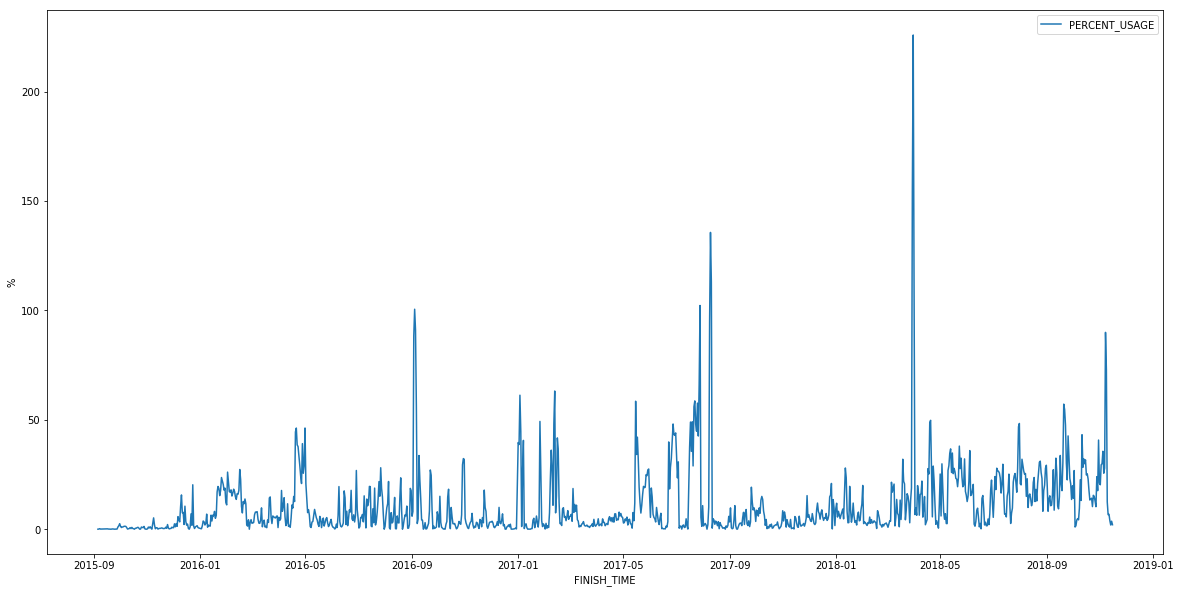

In [3]:
# define a groupby function for usage
def usage_f(x):
    instance = x['INSTANCE_UUID'].nunique()
    vcpus = x.groupby('INSTANCE_UUID').VCPUS.first().sum()
    memory = x.groupby('INSTANCE_UUID').MEMORY_MB.first().sum() / 1024
    disk = x.groupby('INSTANCE_UUID').DISK_GB.first().sum()
    return pd.Series([instance, vcpus, memory, disk], index=['INSTANCE_COUNT','TOTAL_VCPUS', 'MEMORY_USAGE_IN_GB', 'DISK_USAGE_IN_GB'])

# excludes failed records
filter_success_df = df.loc[df['RESULT'] == 'Success']

normalized_yearly_usage_df = filter_success_df.groupby(filter_success_df['FINISH_TIME'].dt.date).apply(usage_f)
normalized_yearly_usage_df = normalized_yearly_usage_df.reset_index()[['FINISH_TIME', 'TOTAL_VCPUS']]
normalized_yearly_usage_df['AVAILABLE_VCPUS'] = [6000.0 if str(d) < '2017-07-14' else 3848.0 for d in normalized_yearly_usage_df['FINISH_TIME']]
normalized_yearly_usage_df['PERCENT_USAGE'] = (normalized_yearly_usage_df['TOTAL_VCPUS'] / normalized_yearly_usage_df['AVAILABLE_VCPUS']) * 100
normalized_yearly_usage_df = normalized_yearly_usage_df[['FINISH_TIME', 'PERCENT_USAGE']].set_index('FINISH_TIME')
ax = normalized_yearly_usage_df.plot(figsize = (20, 10))
ax.set_ylabel('%')
plt.show()

#### What are the dates of the spikes (usage over 100%)?

In [4]:
spike_df = normalized_yearly_usage_df[normalized_yearly_usage_df['PERCENT_USAGE'] > 100].sort_values(by = 'PERCENT_USAGE', ascending = False)
spike_df

,PERCENT_USAGE
FINISH_TIME,
2018-03-31,225.883576
2018-03-30,154.365904
2017-08-10,135.654886
2017-08-11,112.967775
2018-04-01,106.678794
2017-07-29,102.260915
2016-09-04,100.550000


#### Are the spikes caused by the work of one project / user or many?

In [5]:
# what happened on 2018-03-31?
filter_success_df = df.loc[df['RESULT'] == 'Success']
traces_on_spike_day_df = filter_success_df[filter_success_df['FINISH_TIME'].dt.date == spike_df.reset_index().iloc[0]['FINISH_TIME']]
traces_on_spike_day_df.groupby(['USER_ID', 'PROJECT_ID']).agg({'INSTANCE_UUID': pd.Series.nunique}).sort_values('INSTANCE_UUID', ascending=False).head(3)

,,INSTANCE_UUID
USER_ID,PROJECT_ID,
mhp,FG-54,1057
aiorhean,CH-819402,50
openlab,CH-819710,14


In [6]:
# what happened on 2017-08-10?
filter_success_df = df.loc[df['RESULT'] == 'Success']
traces_on_spike_day_df = filter_success_df[filter_success_df['FINISH_TIME'].dt.date == spike_df.reset_index().iloc[2]['FINISH_TIME']]
traces_on_spike_day_df.groupby(['USER_ID', 'PROJECT_ID']).agg({'INSTANCE_UUID': pd.Series.nunique}).sort_values('INSTANCE_UUID', ascending=False).head(3)

,,INSTANCE_UUID
USER_ID,PROJECT_ID,
mhp,FG-54,650
md1,CH-816919,9
cctest,Chameleon,1


In [7]:
# what happened on 2018-04-01?
filter_success_df = df.loc[df['RESULT'] == 'Success']
traces_on_spike_day_df = filter_success_df[filter_success_df['FINISH_TIME'].dt.date == spike_df.reset_index().iloc[4]['FINISH_TIME']]
traces_on_spike_day_df.groupby(['USER_ID', 'PROJECT_ID']).agg({'INSTANCE_UUID': pd.Series.nunique}).sort_values('INSTANCE_UUID', ascending=False).head(3)

,,INSTANCE_UUID
USER_ID,PROJECT_ID,
mhp,FG-54,504
drobin,CH-819892,9
openlab,CH-819710,7


In [8]:
# what happened on 2017-07-29?
filter_success_df = df.loc[df['RESULT'] == 'Success']
traces_on_spike_day_df = filter_success_df[filter_success_df['FINISH_TIME'].dt.date == spike_df.reset_index().iloc[5]['FINISH_TIME']]
traces_on_spike_day_df.groupby(['USER_ID', 'PROJECT_ID']).agg({'INSTANCE_UUID': pd.Series.nunique}).sort_values('INSTANCE_UUID', ascending=False).head(3)

,,INSTANCE_UUID
USER_ID,PROJECT_ID,
mhp,FG-54,488
eunosm3,CH-818664,22
smithky,CH-818664,8


In [9]:
# what happened on 2016-09-04?
filter_success_df = df.loc[df['RESULT'] == 'Success']
traces_on_spike_day_df = filter_success_df[filter_success_df['FINISH_TIME'].dt.date == spike_df.reset_index().iloc[6]['FINISH_TIME']]
traces_on_spike_day_df.groupby(['USER_ID', 'PROJECT_ID']).agg({'INSTANCE_UUID': pd.Series.nunique}).sort_values('INSTANCE_UUID', ascending=False).head(3)

,,INSTANCE_UUID
USER_ID,PROJECT_ID,
mhp,FG-54,754
cctest,Chameleon,1


#### What if we exclude the user / project who is responsible for the spikes?

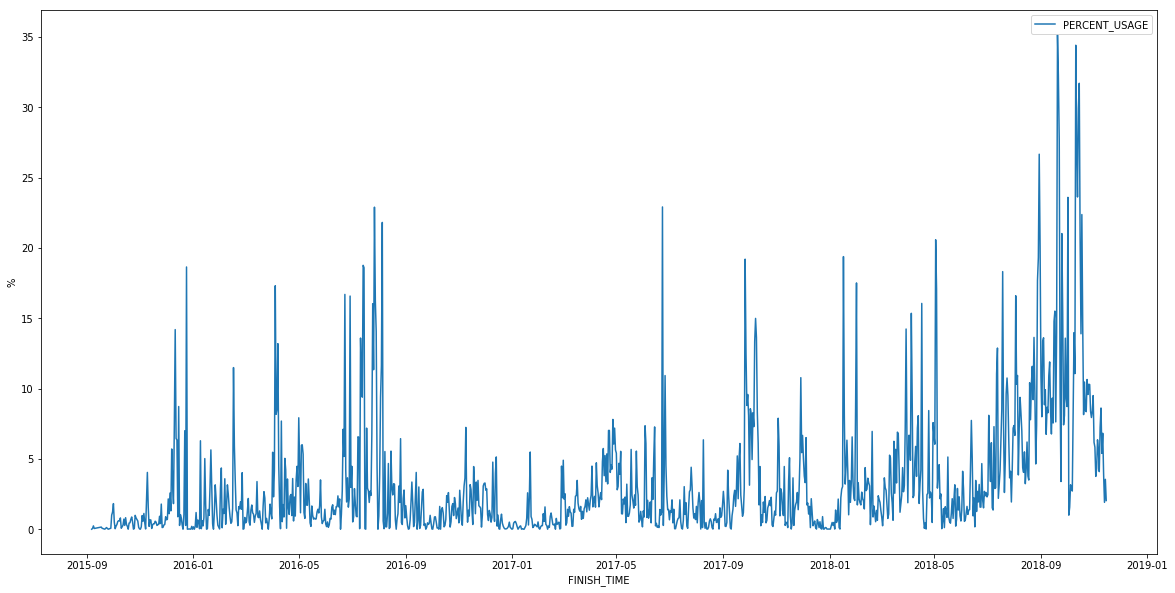

In [10]:
# exclude user mhp and project FG-54
yearly_usage_exclusion_df = filter_success_df.loc[filter_success_df['USER_ID'] != 'mhp'].loc[filter_success_df['PROJECT_ID'] != 'FG-54']
yearly_usage_exclusion_df = yearly_usage_exclusion_df.groupby(yearly_usage_exclusion_df['FINISH_TIME'].dt.date).apply(usage_f)

normalized_yearly_usage_exclusion_df = yearly_usage_exclusion_df.reset_index()[['FINISH_TIME', 'TOTAL_VCPUS']]
normalized_yearly_usage_exclusion_df['AVAILABLE_VCPUS'] = [6000.0 if str(d) < '2017-07-14' else 3848.0 for d in normalized_yearly_usage_exclusion_df['FINISH_TIME']]
normalized_yearly_usage_exclusion_df['PERCENT_USAGE'] = (normalized_yearly_usage_exclusion_df['TOTAL_VCPUS'] / normalized_yearly_usage_exclusion_df['AVAILABLE_VCPUS']) * 100
normalized_yearly_usage_exclusion_df = normalized_yearly_usage_exclusion_df[['FINISH_TIME', 'PERCENT_USAGE']].set_index('FINISH_TIME').apply(lambda x: [y if y <= 100 else 100 for y in x])
ax = normalized_yearly_usage_exclusion_df.plot(figsize = (20, 10))
ax.set_ylabel('%')
plt.show()

#### Chameleon KVM site outage dates

In [11]:
outage_dates_df = normalized_yearly_usage_df[normalized_yearly_usage_df['PERCENT_USAGE'] <= 0]
outage_dates_df

,PERCENT_USAGE
FINISH_TIME,


#### Conclusions
1) There is a usage growing in the past 6 months.

2) The spikes are caused by the experiments from a particular user `mhp` of a particular project `FG-54`.

3) Chameleon KVM site has no shut-down times.


### 2. Is there a weekly usage pattern of KVM?

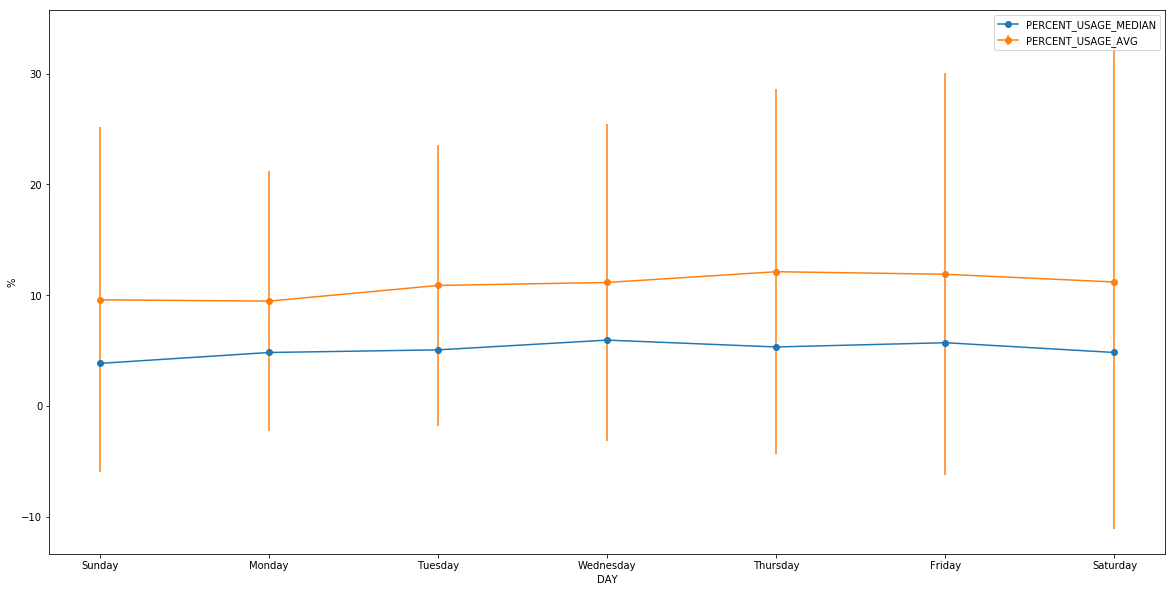

In [12]:
# weekly / daily usage plot
def weekyly_daily_usage_plot(ax, median_df, average_df, std_df, measure, ylabel, xlabel):
    ax.plot(median_df[xlabel], median_df[measure], marker='o')
    ax.errorbar(average_df[xlabel], average_df[measure], yerr=std_df[measure], fmt='o', ls='-')
    ax.set_ylabel(ylabel)
    ax.legend([measure + '_MEDIAN', measure + '_AVG'], loc='upper right');
    
filter_success_df = df.loc[df['RESULT'] == 'Success']

# day of week order
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

weekly_usage_df = filter_success_df.groupby([filter_success_df['FINISH_TIME'].dt.date, filter_success_df['FINISH_TIME'].dt.weekday_name]).apply(usage_f)
weekly_usage_df = weekly_usage_df.rename_axis(['DATE', 'DAY']).reset_index()
normalized_weekly_usage_df = weekly_usage_df.reset_index()[['DATE', 'DAY', 'TOTAL_VCPUS']]
normalized_weekly_usage_df['AVAILABLE_VCPUS'] = [6000.0 if str(d) < '2017-07-14' else 3848.0 for d in normalized_weekly_usage_df['DATE']]
normalized_weekly_usage_df['PERCENT_USAGE'] = (normalized_weekly_usage_df['TOTAL_VCPUS'] / normalized_weekly_usage_df['AVAILABLE_VCPUS']) * 100
normalized_weekly_usage_df = normalized_weekly_usage_df[['DAY', 'PERCENT_USAGE']].set_index('DAY')

# average 
average_weekly_usage_df = normalized_weekly_usage_df.groupby('DAY').mean()
average_weekly_usage_df = average_weekly_usage_df.reindex(weekday_order)
average_weekly_usage_df['DAY'] = average_weekly_usage_df.index
# median
median_weekly_usage_df = normalized_weekly_usage_df.groupby('DAY').median()
median_weekly_usage_df = median_weekly_usage_df.reindex(weekday_order)
median_weekly_usage_df['DAY'] = median_weekly_usage_df.index
# std
std_weekly_usage_df = normalized_weekly_usage_df.groupby('DAY').std()
std_weekly_usage_df = std_weekly_usage_df.reindex(weekday_order)
std_weekly_usage_df['DAY'] = std_weekly_usage_df.index

fig, ax = plt.subplots(nrows=1, figsize=(20,10))
weekyly_daily_usage_plot(ax, median_weekly_usage_df, average_weekly_usage_df, std_weekly_usage_df, 'PERCENT_USAGE', '%', 'DAY')
ax.set_xlabel('DAY')

plt.show()

#### Conclusions
No obvious weekly usage pattern was found. 


### 3. Is there a daily usage pattern of KVM?

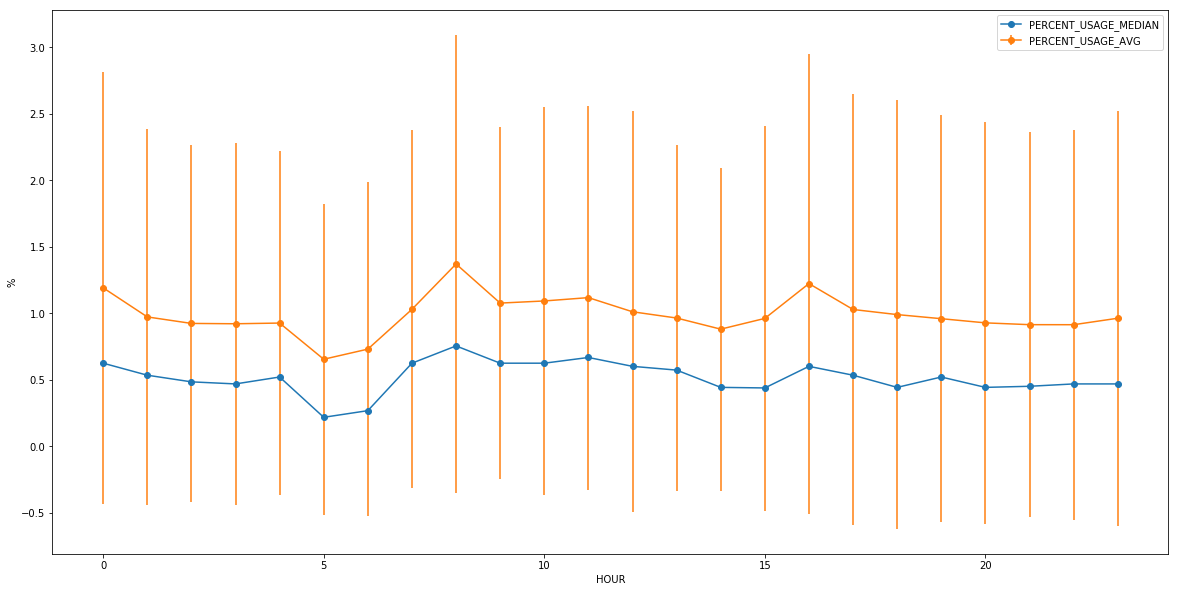

In [13]:
filter_success_df = df.loc[df['RESULT'] == 'Success']

# average, median, and std
daily_usage_df = filter_success_df.groupby([filter_success_df['FINISH_TIME'].dt.date, filter_success_df['FINISH_TIME'].dt.hour]).apply(usage_f)
daily_usage_df = daily_usage_df.rename_axis(['DATE', 'HOUR']).reset_index()
normalized_daily_usage_df = daily_usage_df.reset_index()[['DATE', 'HOUR', 'TOTAL_VCPUS']]
normalized_daily_usage_df['AVAILABLE_VCPUS'] = [6000.0 if str(d) < '2017-07-14' else 3848.0 for d in normalized_daily_usage_df['DATE']]
normalized_daily_usage_df['PERCENT_USAGE'] = (normalized_daily_usage_df['TOTAL_VCPUS'] / normalized_daily_usage_df['AVAILABLE_VCPUS']) * 100
normalized_daily_usage_df = normalized_daily_usage_df[['HOUR', 'PERCENT_USAGE']].set_index('HOUR')
# average 
average_daily_usage_df = normalized_daily_usage_df.groupby('HOUR').mean().reset_index()
# median
median_daily_usage_df = normalized_daily_usage_df.groupby('HOUR').median().reset_index()
# std
std_daily_usage_df = normalized_daily_usage_df.groupby('HOUR').std().reset_index()

fig, ax = plt.subplots(nrows=1, figsize=(20,10))
weekyly_daily_usage_plot(ax, median_daily_usage_df, average_daily_usage_df, std_daily_usage_df, 'PERCENT_USAGE', '%', 'HOUR')
ax.set_xlabel('HOUR')

plt.show()

#### Conclusions

1) The usage in the early morning is relative low.

2) The usage peaks are around 8 in the morning and 4 in the afternoon.


### 4. What is the VCPU usage per rack?

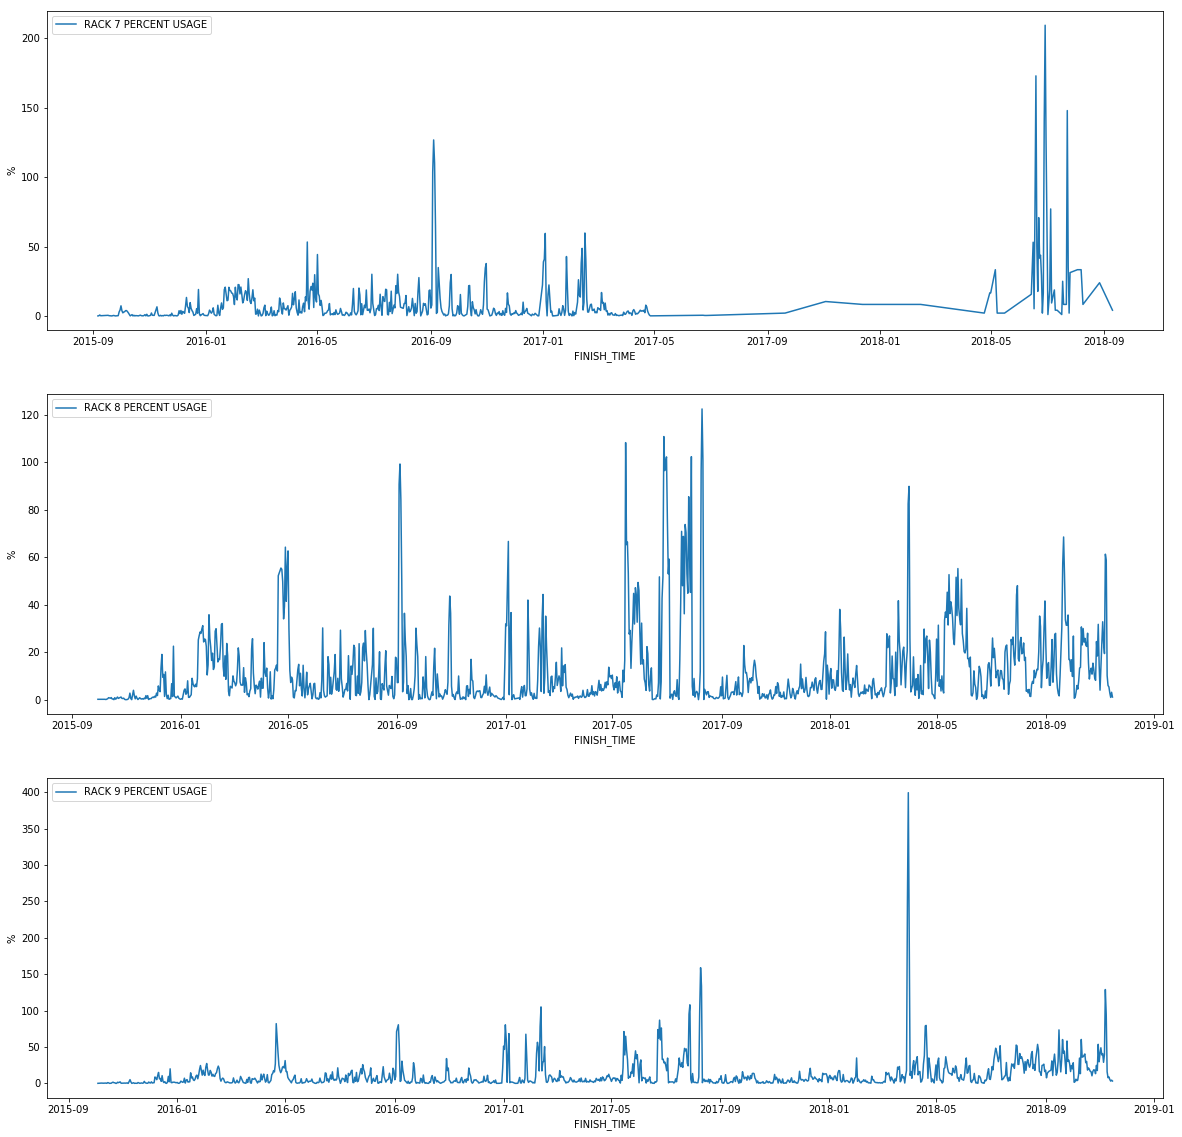

In [14]:
# excludes failed records
filter_success_df = df.loc[df['RESULT'] == 'Success']

def get_normalized_yearly_usage_by_rack(rack_name, available_vcpus_before_2017_07_14, available_vcpus_after_2017_07_14):
    # excludes rows whose hostname is null
    filter_rack_success_df = filter_success_df[filter_success_df['HOST_NAME (PHYSICAL)'].notnull()]
    
    filter_rack_success_df = filter_rack_success_df[filter_rack_success_df['HOST_NAME (PHYSICAL)'].str.match(rack_name)]
    normalized_rack_yearly_usage_df = filter_rack_success_df.groupby(filter_rack_success_df['FINISH_TIME'].dt.date).apply(usage_f)
    normalized_rack_yearly_usage_df = normalized_rack_yearly_usage_df.reset_index()[['FINISH_TIME', 'TOTAL_VCPUS']]
    normalized_rack_yearly_usage_df['AVAILABLE_VCPUS'] = [available_vcpus_before_2017_07_14 if str(d) < '2017-07-14' else available_vcpus_after_2017_07_14 for d in normalized_rack_yearly_usage_df['FINISH_TIME']]
    normalized_rack_yearly_usage_df['PERCENT_USAGE'] = (normalized_rack_yearly_usage_df['TOTAL_VCPUS'] / normalized_rack_yearly_usage_df['AVAILABLE_VCPUS']) * 100
    return normalized_rack_yearly_usage_df[['FINISH_TIME', 'PERCENT_USAGE']].set_index('FINISH_TIME')    

# rack 7
normalized_c07_yearly_usage_df = get_normalized_yearly_usage_by_rack('c07', 2076.0, 96.0)

# rack 8
normalized_c08_yearly_usage_df = get_normalized_yearly_usage_by_rack('c08', 2080.0, 2032.0)

# rack 9
normalized_c09_yearly_usage_df = get_normalized_yearly_usage_by_rack('c09', 1768.0, 1720.0)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,20))
normalized_c07_yearly_usage_df.plot(ax=axes[0])
normalized_c08_yearly_usage_df.plot(ax=axes[1])
normalized_c09_yearly_usage_df.plot(ax=axes[2])
axes[0].set_ylabel('%')
axes[1].set_ylabel('%')
axes[2].set_ylabel('%')
axes[0].legend(labels=['RACK 7 PERCENT USAGE'], loc='upper left')
axes[1].legend(labels=['RACK 8 PERCENT USAGE'], loc='upper left')
axes[2].legend(labels=['RACK 9 PERCENT USAGE'], loc='upper left')
plt.show()

### 5. How many users / projects are using KVMs?

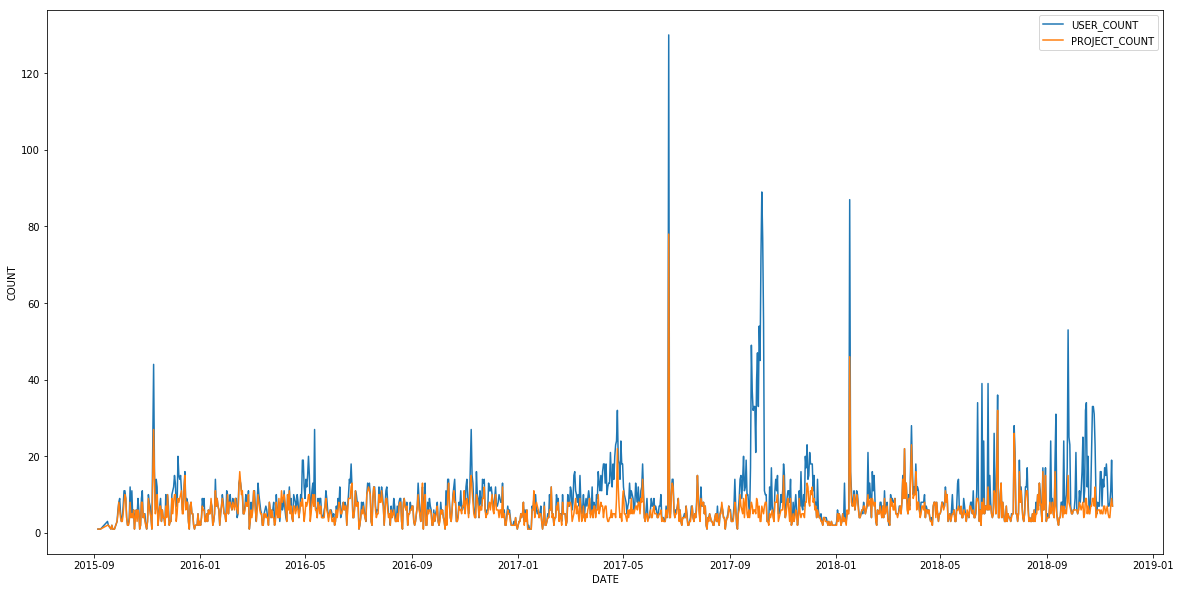

In [15]:
# define a groupby function for users / projects
def user_project_f(x):
    user = x['USER_ID'].nunique()
    project = x['PROJECT_ID'].nunique()
    return pd.Series([user, project], index=['USER_COUNT', 'PROJECT_COUNT'])

user_project_df = df.groupby(df['FINISH_TIME'].dt.date).apply(user_project_f)
ax = user_project_df.plot(figsize=(20,10))
ax.set_xlabel("DATE")
ax.set_ylabel("COUNT")
plt.show()

#### What are the projects that used KVM@TACC site the most in 4 years?

In [16]:
filter_success_df = df.loc[df['RESULT'] == 'Success']
heavy_project_df = filter_success_df.groupby(['PROJECT_ID']).size().to_frame('NUM_RECORDS').sort_values(by = 'NUM_RECORDS', ascending=False)
heavy_project_df.head(10)

,NUM_RECORDS
PROJECT_ID,
FG-54,128559
CH-819710,27591
CH-818664,11427
CH-819402,4792
CH-817724,4743
CH-818144,3743
CH-816925,3638
CH-819381,3533
Chameleon,3379


#### What are the projects that used KVM@TACC site the most in the past 6 months?

In [17]:
filter_success_df = df.loc[df['RESULT'] == 'Success']
past_6_heavy_project_df = filter_success_df[filter_success_df['FINISH_TIME'].dt.date >= datetime.date(year=2018,month=5,day=1)]
past_6_heavy_project_df = past_6_heavy_project_df.groupby(['PROJECT_ID']).size().to_frame('NUM_RECORDS').sort_values(by = 'NUM_RECORDS', ascending=False)
past_6_heavy_project_df.head(10)

,NUM_RECORDS
PROJECT_ID,
FG-54,26682
CH-819710,23456
CH-819381,2817
CH-820077,1564
Chameleon,525
CH-818469,445
CH-819933,403
CH-817567,354
CH-820189,299


1) Project `FG-54`

No description; A group of researchers from the [University of Victoria][1].

2) Project `CH-819710`

Project description:

What are the research challenges or educational objectives of the project? Within Open Source individual projects are challenged with "keeping the lights on" with enough developers/engineers to solidify and maintain a certain degree of relevance. OpenLab aims to assist with the propagation of the efficiencies of one of the many successful Open Source communities; OpenStack Community.

How are they relevant to cloud computing research?
OpenStack itself is a stack of software addressing the IaaS layer of cloud computing. Building upon the lessons learned from the OpenStack community other individual projects and stacks of projects can provide relevant "real world" usable solutions to cloud computing beyond IaaS; edge, fintech, etc.

Why are they important?
Open Source has been key to a lot of the technological leaps of the past, present, and will be for those of the future. We are currently and have been for some time in a place within the Open Source community where many companies are infusing projects - individually or collectively - with resources that easily translate dollars to commits but not necessarily dollars to community health. Healthy Open Source projects/communities work well together and it is important to offer a place for this to happen early and often throughout the lifecycle of Open Source individual projects and stacks of projects.

What types of experiments or educational activities will be carried out?
We will experiment with the integration of stacks of Open Source projects that address a particular problem space within cloud computing. One example is related to Edge computing where currently there are a lot of different options and suggestions but not a lot of testing and validation happening in the open. Working with the OpenStack Foundation and OpenStack community we are helping to find a solid combination of Open Source projects that address Edge computing use cases and offer the data from our testing to the Open Source community to push Edge computing forward in a more rapid pace with a trusted stack of Open Source projects.

[1]: https://www.uvic.ca/

### 6. What type of KVMs does user usually choose for their experiments?

In OpenStack, flavors define the compute, memory, and storage capacity of nova computing instances. To put it simply, a flavor is an available hardware configuration for a server. It defines the size of a virtual server that can be launched. [\[1\]][1].

[1]: https://docs.openstack.org/horizon/latest/admin/manage-flavors.html

#### Instance flavors available on Chameleon KVM@TACC

In [18]:
flavors = [
    {
        'FLAVOR': 'm1.tiny',
        'VCPUS': 1,
        'DISK_GB': 1,
        'MEMORY_MB': 512
    },
    {
        'FLAVOR': 'm1.small',
        'VCPUS': 1,
        'DISK_GB': 20,
        'MEMORY_MB': 2048
    },
    {
        'FLAVOR': 'm1.medium',
        'VCPUS': 2,
        'DISK_GB': 40,
        'MEMORY_MB': 4096
    },
    {
        'FLAVOR': 'storage.medium',
        'VCPUS': 1,
        'DISK_GB': 2048,
        'MEMORY_MB': 4096
    },
    {
        'FLAVOR': 'm1.large',
        'VCPUS': 4,
        'DISK_GB': 80,
        'MEMORY_MB': 8192
    },
    {
        'FLAVOR': 'm1.xlarge',
        'VCPUS': 8,
        'DISK_GB': 160,
        'MEMORY_MB': 16384
    },
    {
        'FLAVOR': 'm1.xxlarge',
        'VCPUS': 8,
        'DISK_GB': 160,
        'MEMORY_MB': 32768
    },
    {
        'FLAVOR': 'm1.xxxlarge',
        'VCPUS': 16,
        'DISK_GB': 160,
        'MEMORY_MB': 32768
    }
]
flavors_df = pd.DataFrame(flavors)[['FLAVOR', 'VCPUS', 'MEMORY_MB', 'DISK_GB']]
flavors_df

,FLAVOR,VCPUS,MEMORY_MB,DISK_GB
0,m1.tiny,1,512,1
1,m1.small,1,2048,20
2,m1.medium,2,4096,40
3,storage.medium,1,4096,2048
4,m1.large,4,8192,80
5,m1.xlarge,8,16384,160
6,m1.xxlarge,8,32768,160
7,m1.xxxlarge,16,32768,160


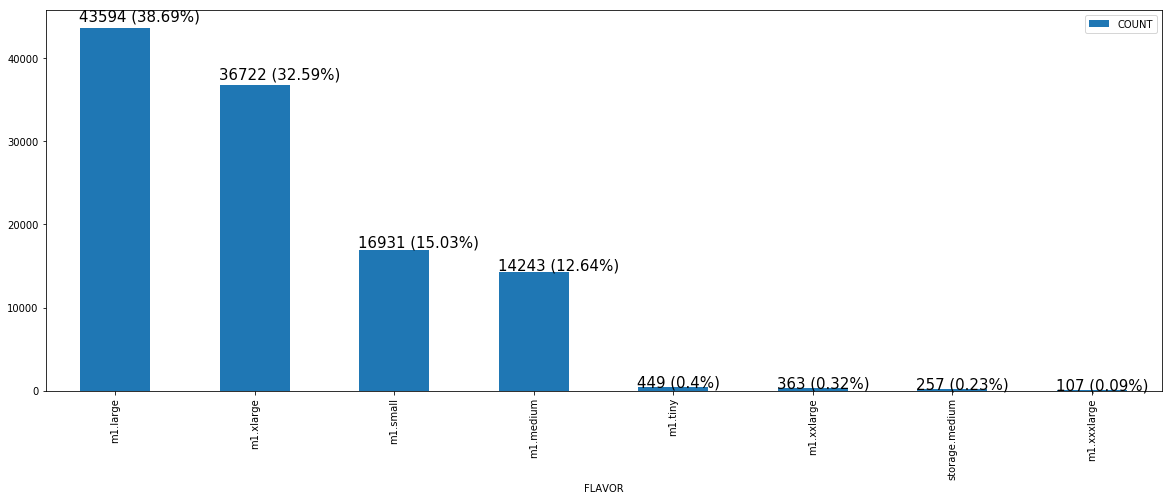

In [77]:
filter_success_df = df.loc[df['RESULT'] == 'Success']

# function for plotting KVM type
def plot_bar_percent(df, figsize, fontsize):
    ax = df.plot(kind='bar', figsize=figsize)
    
    # create a list to collect the plt.patches data
    totals = []
    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_height())

    # set individual bar lables using above list
    total = sum(totals)
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()-.01, i.get_height()*1.02, str(i.get_height()) + ' (' + str(round((i.get_height()/total)*100, 2))+'%)', fontsize=fontsize)
    plt.show()
    

flavor_concat_df = pd.merge(filter_success_df, flavors_df,  how='left', left_on=['VCPUS','MEMORY_MB','DISK_GB'], right_on = ['VCPUS','MEMORY_MB','DISK_GB'])

instance_type_df = flavor_concat_df.groupby('INSTANCE_UUID').first().reset_index()

plot_bar_percent(instance_type_df[['INSTANCE_UUID', 'FLAVOR']].groupby('FLAVOR').size().to_frame('COUNT').sort_values(by=['COUNT'], ascending=False), (20,7), 15)

### 7. How is our KVM platform performed based on different types of events?
`Instance-action-events` are an admin facing log which goes into more details of the compute methods invoked and any stack traces that occurred. 

#### Average event durations with standard deviation

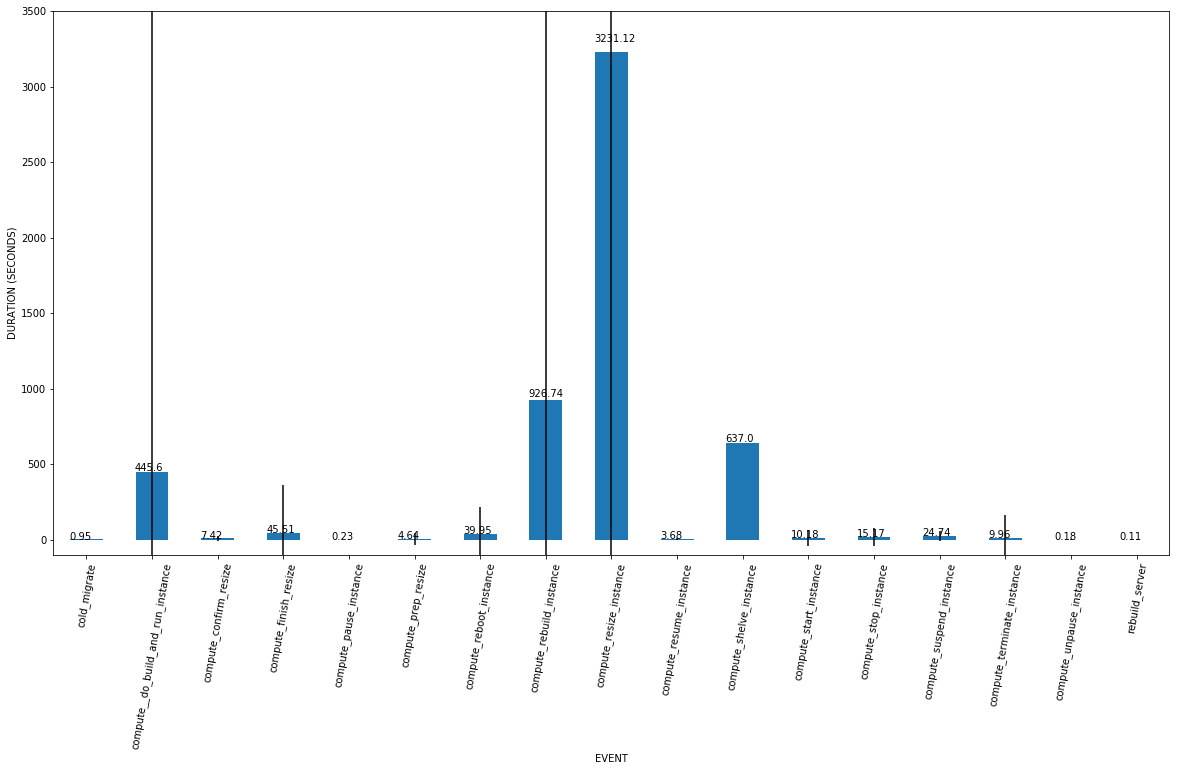

In [20]:
filter_success_df = df.loc[df['RESULT'] == 'Success']

event_group = filter_success_df[['EVENT', 'EVENT_DURATION']].groupby('EVENT')
avg_duration = event_group.mean()
std_duration = event_group.std()

ax = avg_duration.plot(figsize=(20,10),legend=False,kind='bar',rot=80,fontsize=10,yerr=std_duration);
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.01, i.get_height()*1.02, str(round(i.get_height(), 2)), fontsize=10)
ax.set_xlabel('EVENT');
ax.set_ylabel("DURATION (SECONDS)");
ax.set_ylim(-100,3500);

plt.show()

#### Event success rate

We split all types of events into three graphs due to the scale variances. 

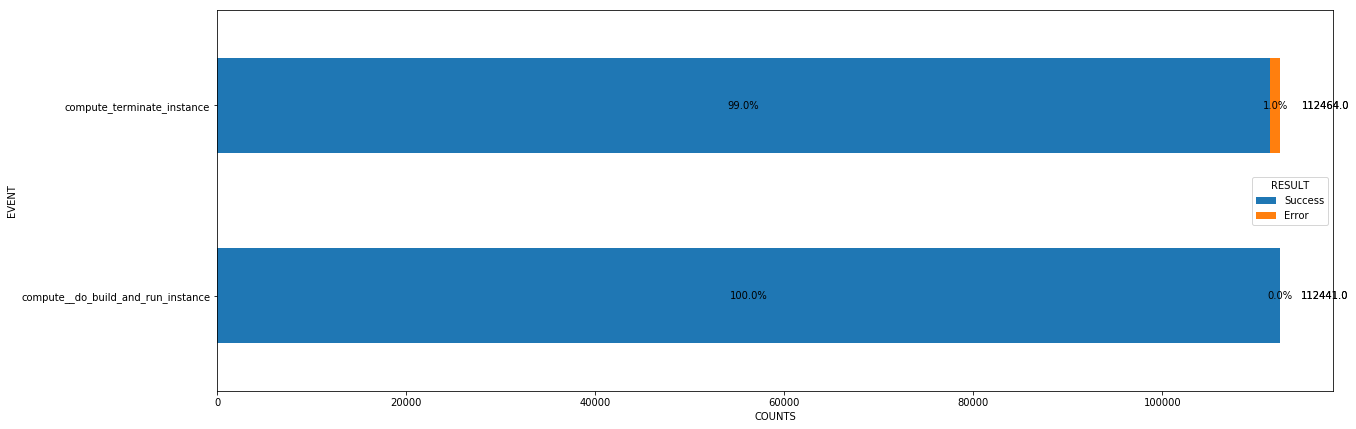

In [21]:

def plot_event_success_rate(df):
    total = df['Success'] + df['Error']
    ax = df.plot(x = 'EVENT', kind='barh',stacked = True, mark_right = True, figsize = (20, 7))
    ax.set_xlabel("COUNTS");

    df_rel = df[df.columns[1:]].div(total, 0)*100

    for n in df_rel:
        for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], df[n], df_rel[n], total)):
            if tot > 100:
                plt.text(tot * 1.02, i, str(tot), va='center')
            elif tot > 20:
                plt.text(tot * 1.07, i, str(tot), va='center')    
            else:
                plt.text(tot * 20, i, str(tot), va='center')
            plt.text(cs - ab/2, i, str(round(pc, 1)) + '%', va='center', ha='center')
            
    plt.show()

event_success_rate_df = df.groupby(['EVENT', 'RESULT']).size().unstack().fillna(0).reset_index()
event_success_rate_df = event_success_rate_df[['EVENT', 'Success', 'Error']]

# split events
most_popular_events = ['compute__do_build_and_run_instance', 'compute_terminate_instance']
popular_events = ['rebuild_server', 'compute_stop_instance', 'compute_start_instance', 'compute_rebuild_instance', 'compute_reboot_instance']

most_popular_event_df = event_success_rate_df.loc[event_success_rate_df['EVENT'].isin(most_popular_events)]
popular_event_df = event_success_rate_df.loc[event_success_rate_df['EVENT'].isin(popular_events)]
least_event_df = event_success_rate_df.loc[~event_success_rate_df['EVENT'].isin(most_popular_events) & ~event_success_rate_df['EVENT'].isin(popular_events)]

plot_event_success_rate(most_popular_event_df)


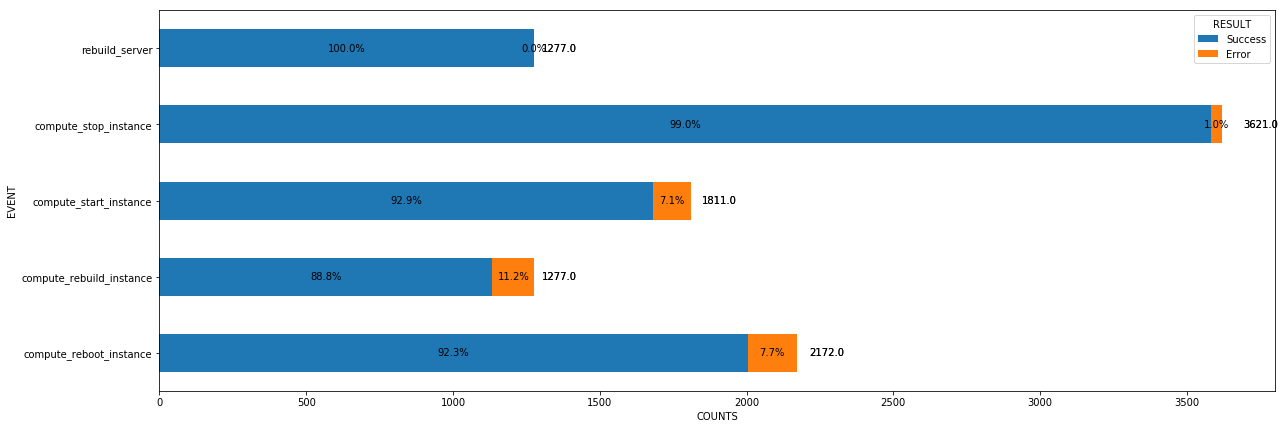

In [22]:
plot_event_success_rate(popular_event_df)

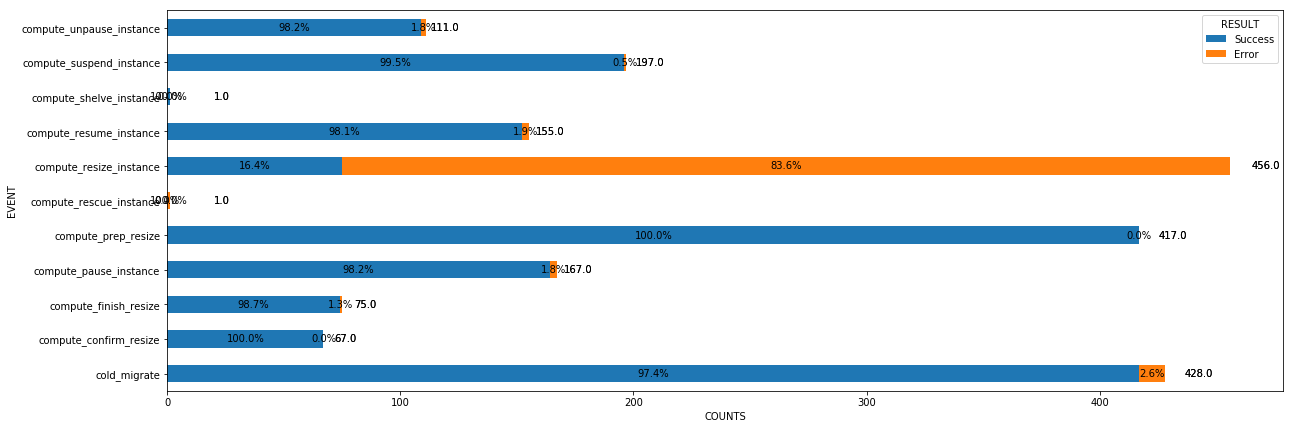

In [23]:
plot_event_success_rate(least_event_df)

#### Conclusions

Chameleon KVM@TACC has very high success rates across different types of events, except `compute_resize_instance`. 

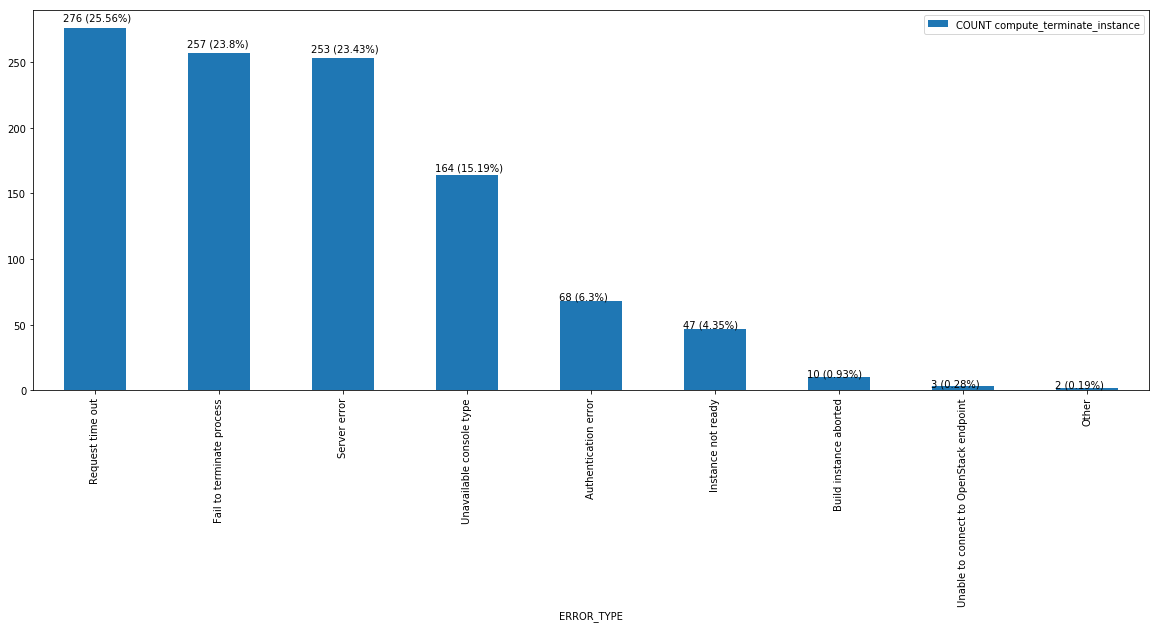

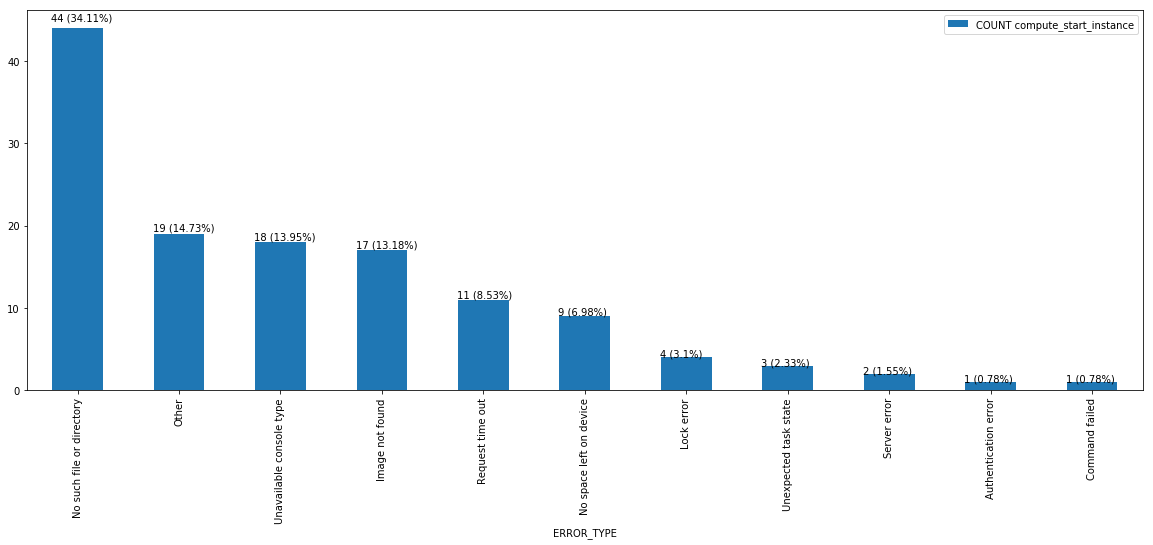

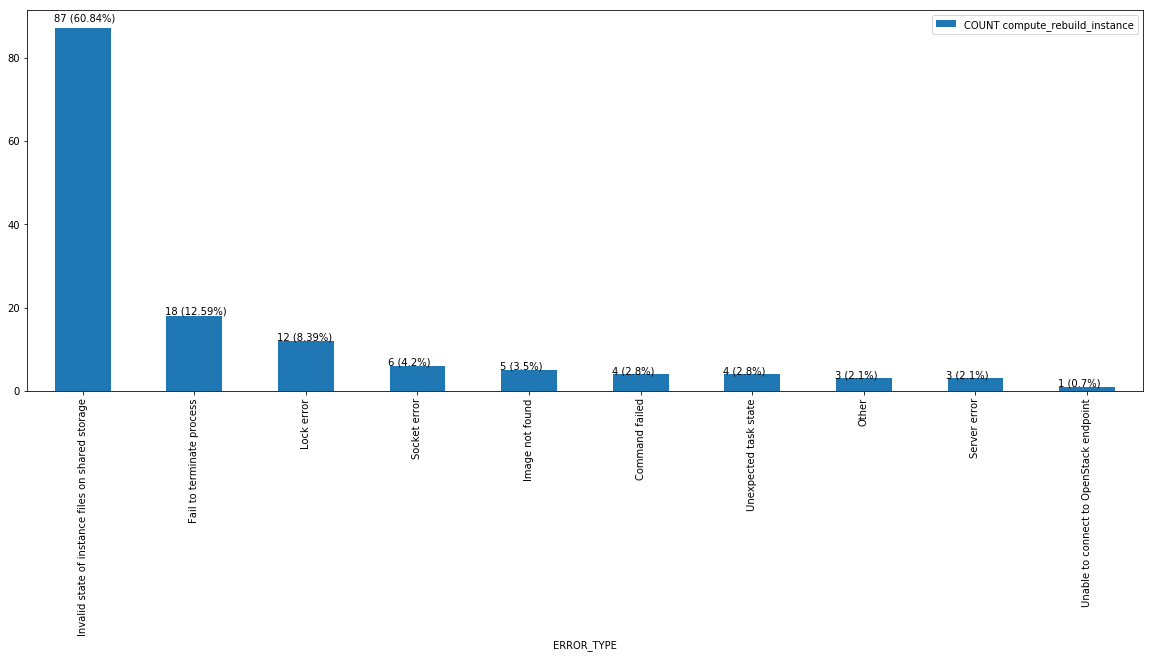

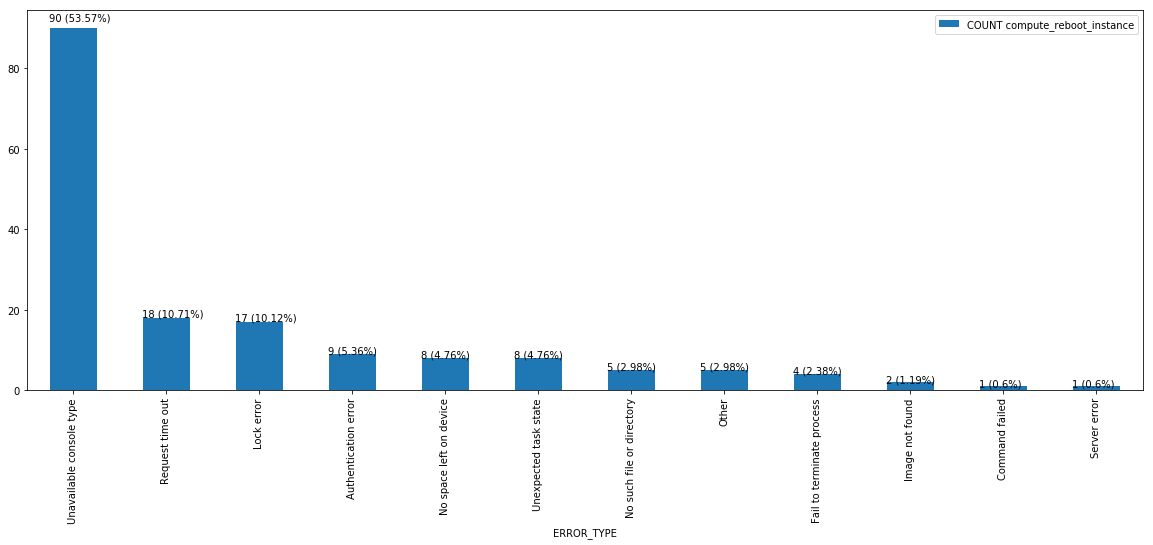

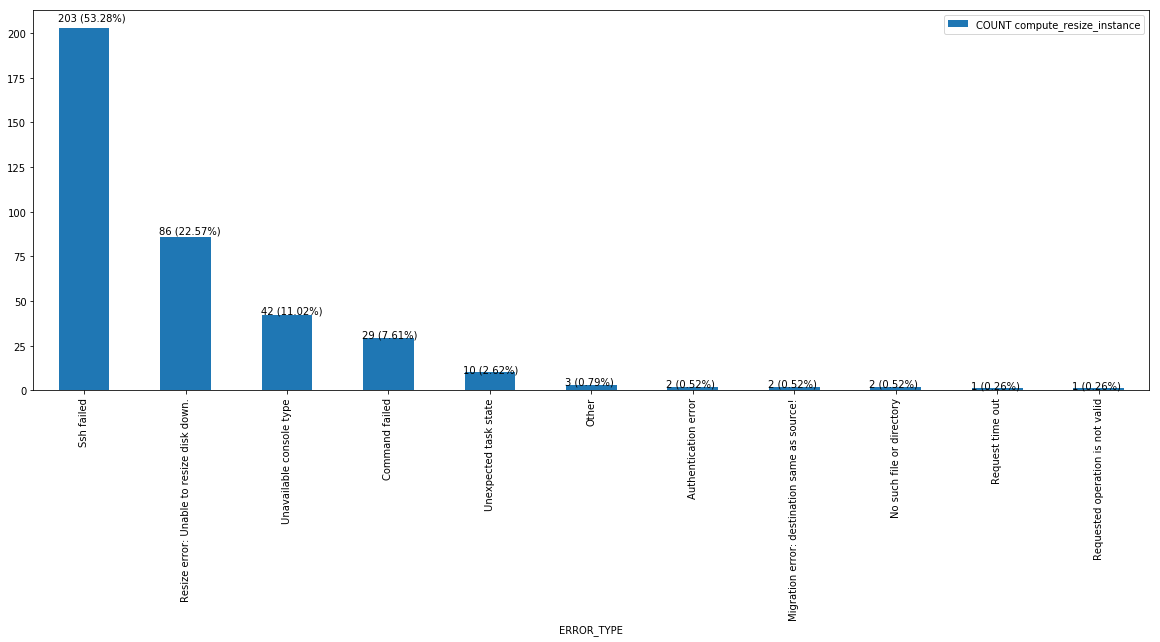

In [81]:
# filter failed records
filter_failure_df = df.loc[df['RESULT'] == 'Error']

def error_type(row):
    if 'time out' in row['ERROR_MESSAGE'].lower() or 'timed out' in row['ERROR_MESSAGE'].lower():
        return 'Request time out'
    elif 'auth' in row['ERROR_MESSAGE'].lower():
        return 'Authentication error'
    elif 'SIGKILL' in row['ERROR_MESSAGE']:
        return 'Fail to terminate process'
    elif 'abort' in row['ERROR_MESSAGE'].lower():
        return 'Build instance aborted'
    elif 'not ready' in row['ERROR_MESSAGE'].lower():
        return 'Instance not ready'
    elif 'server' in row['ERROR_MESSAGE'].lower():
        return 'Server error'
    elif 'unavailable console type' in row['ERROR_MESSAGE'].lower():
        return 'Unavailable console type'
    elif 'connection' in row['ERROR_MESSAGE'].lower():
        return 'Unable to connect to OpenStack endpoint'
    elif 'unexpected task state' in row['ERROR_MESSAGE'].lower():
        return 'Unexpected task state'
    elif 'requested operation is not valid' in row['ERROR_MESSAGE'].lower():
        return 'Requested operation is not valid'
    elif 'lock' in row['ERROR_MESSAGE'].lower():
        return 'Lock error'
    elif 'no space' in row['ERROR_MESSAGE'].lower():
        return 'No space left on device'
    elif 'no such file or directory' in row['ERROR_MESSAGE'].lower():
        return 'No such file or directory'
    elif 'image' in row['ERROR_MESSAGE'].lower():
        return 'Image not found'
    elif 'invalid state of instance files on shared storage' in row['ERROR_MESSAGE'].lower():
        return 'Invalid state of instance files on shared storage'
    elif 'socket' in row['ERROR_MESSAGE'].lower():
        return 'Socket error'
    elif 'command: ssh' in row['ERROR_MESSAGE'].lower():
        return 'Ssh failed'
    elif 'command' in row['ERROR_MESSAGE'].lower():
        return 'Command failed'
    elif 'Resize error: Unable to resize disk down.' in row['ERROR_MESSAGE']:
        return 'Resize error: Unable to resize disk down.'
    elif 'Migration error: destination same as source!' in row['ERROR_MESSAGE']:
        return 'Migration error: destination same as source!'
    else:
        return 'Other'

def get_error_type_count_by_event(event_name):
    filter_event_failure_df = filter_failure_df[filter_failure_df['EVENT'] == event_name]
    event_failure_df = filter_event_failure_df.copy()
    event_failure_df['ERROR_TYPE'] = filter_event_failure_df.apply(lambda row: error_type(row), axis=1)
    return event_failure_df.groupby('ERROR_TYPE').size().to_frame('COUNT ' + event_name).sort_values(by='COUNT ' + event_name, ascending=False)

# compute_terminate_instance
compute_terminate_instance_failure_df = get_error_type_count_by_event('compute_terminate_instance')
plot_bar_percent(compute_terminate_instance_failure_df, (20,7), 10)

# compute_start_instance
compute_start_instance_failure_df = get_error_type_count_by_event('compute_start_instance')
plot_bar_percent(compute_start_instance_failure_df, (20,7), 10)

# compute_rebuild_instance
compute_rebuild_instance_failure_df = get_error_type_count_by_event('compute_rebuild_instance')
plot_bar_percent(compute_rebuild_instance_failure_df, (20,7), 10)

# compute_reboot_instance
compute_reboot_instance_failure_df = get_error_type_count_by_event('compute_reboot_instance')
plot_bar_percent(compute_reboot_instance_failure_df, (20,7), 10)

# compute_resize_instance
compute_resize_instance_failure_df = get_error_type_count_by_event('compute_resize_instance')
plot_bar_percent(compute_resize_instance_failure_df, (20,7), 10)

### 8. How long KVMs last from creation to termination (KVM lifetimes)?

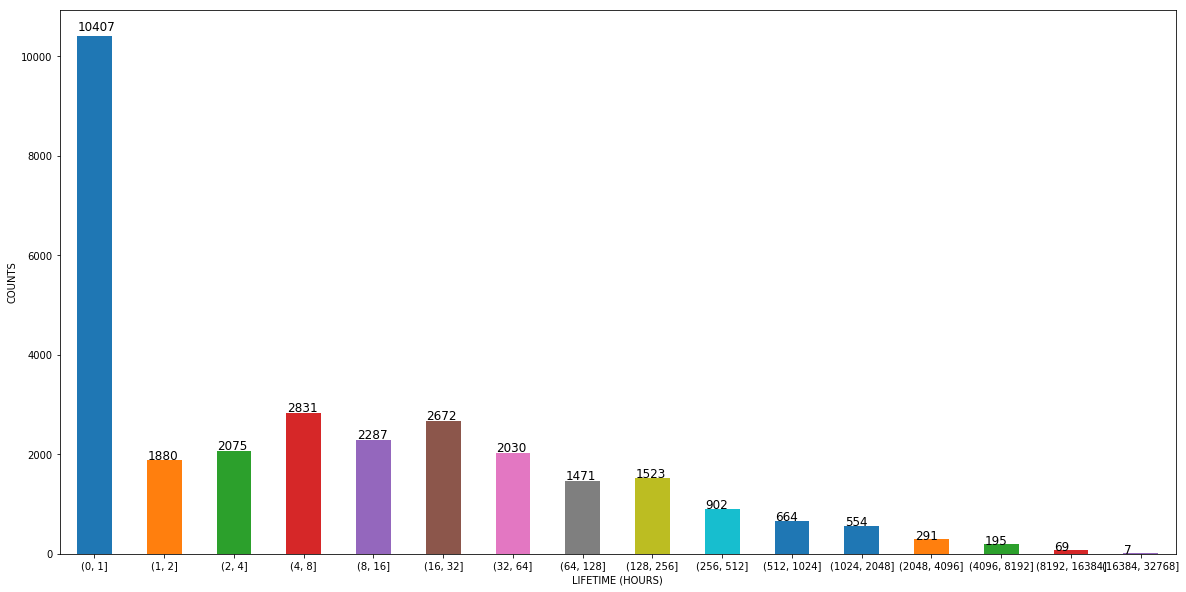

In [24]:
filter_success_df = df.loc[df['RESULT'] == 'Success']

kvm_lifetime_df = filter_success_df[['INSTANCE_UUID', 'EVENT', 'FINISH_TIME']]
kvm_lifetime_df = kvm_lifetime_df.loc[kvm_lifetime_df['EVENT'].isin(most_popular_events)]
# pivot dataframe
kvm_lifetime_df = kvm_lifetime_df.groupby(['INSTANCE_UUID', 'EVENT'])['FINISH_TIME'].aggregate('first').unstack().reset_index()
# remove null
kvm_lifetime_df = kvm_lifetime_df[kvm_lifetime_df.compute__do_build_and_run_instance.notnull() & kvm_lifetime_df.compute_terminate_instance.notnull()]
# calculate lifetime in hours
kvm_lifetime_df['LIFETIME'] = (kvm_lifetime_df['compute_terminate_instance'] - kvm_lifetime_df['compute__do_build_and_run_instance']).astype('timedelta64[h]')
kvm_lifetime_df = kvm_lifetime_df[['INSTANCE_UUID', 'LIFETIME']]

# cut lifetime into bins
kvm_lifetime_cut= pd.cut(kvm_lifetime_df['LIFETIME'], [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768])

ax = kvm_lifetime_cut.value_counts(sort=False).plot.bar(rot=0, figsize=(20,10))
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.01, i.get_height()*1.01, str(i.get_height()), fontsize=12)
ax.set_xlabel('LIFETIME (HOURS)')
ax.set_ylabel('COUNTS')
plt.show()

### 9. How many KVMs in each deployment?
We assume that instances with the same `hostname` prefix belongs to one deployment.

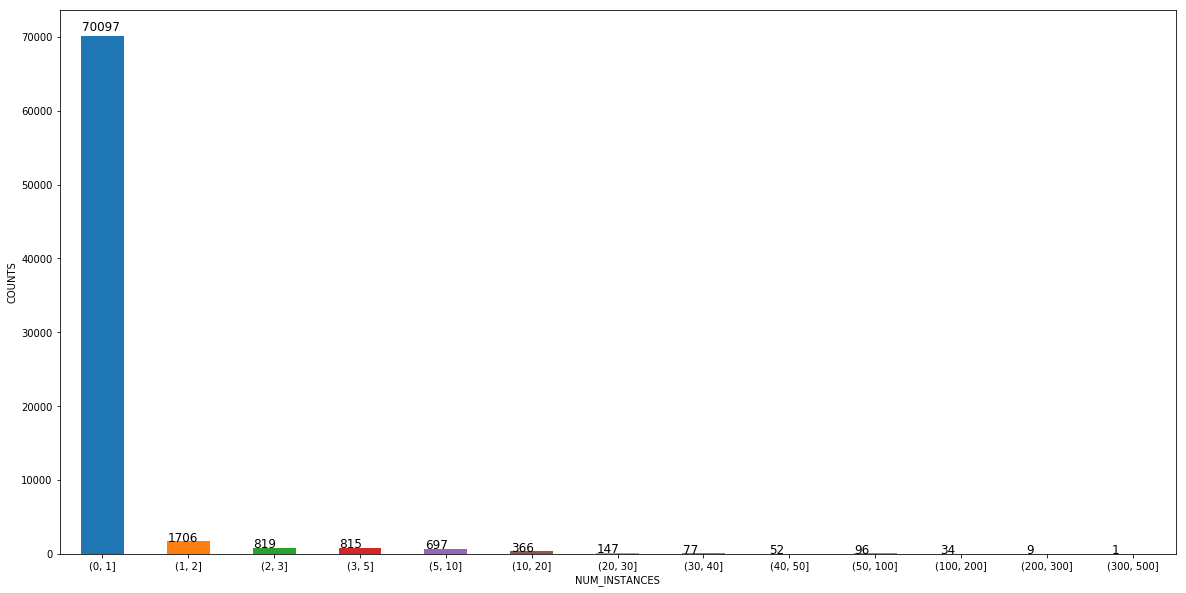

In [54]:
import re

def find_deployment(row):
    m = re.search(r'(.+)-(\d+)$', row['INSTANCE_NAME'])
    if m is not None:
        return m.group(1)
    else:
        return row['INSTANCE_NAME']

# excludes failed records
filter_success_df = df.loc[df['RESULT'] == 'Success']
filter_deploy_event_df = filter_success_df[filter_success_df['EVENT'] == 'compute__do_build_and_run_instance']
deploy_event_df = filter_deploy_event_df.copy()
deploy_event_df['INSTANCE_DEPLOY_NAME'] = filter_deploy_event_df.apply(lambda row: find_deployment(row), axis=1)
deployment_df = deploy_event_df.groupby(['USER_ID', 'PROJECT_ID', 'INSTANCE_DEPLOY_NAME', deploy_event_df['FINISH_TIME'].dt.date]).agg({'FINISH_TIME': [np.max, np.min], 'INSTANCE_UUID': pd.Series.nunique})
deployment_df.columns = ['MAX_TIME', 'MIN_TIME', 'NUM_INSTANCES']
deployment_df['TIME_DIFF'] = (deployment_df['MAX_TIME'] - deployment_df['MIN_TIME']).astype('timedelta64[s]')
deployment_df = deployment_df.reset_index()
deployment_df = deployment_df[['INSTANCE_DEPLOY_NAME', 'NUM_INSTANCES']]

# cut number of instances into bins
deployment_count_cut= pd.cut(deployment_df['NUM_INSTANCES'], [0, 1, 2, 3, 5, 10, 20, 30, 40, 50, 100, 200, 300, 500])
deployment_count_cut

ax = deployment_count_cut.value_counts(sort=False).plot.bar(rot=0, figsize=(20,10))
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.01, i.get_height()*1.01, str(i.get_height()), fontsize=12)
ax.set_xlabel('NUM_INSTANCES')
ax.set_ylabel('COUNTS')
plt.show()

### 10. What percentage is classroom use?

We assume that if multiple users (more than 5) from one project launched KVMs in the same day, KVMs were used by a classroom.

First, we check if our assumption makes sense by picking out projects we think are classroom projects. 

In [26]:
classroom_use_df = df[df['EVENT'] == 'compute__do_build_and_run_instance'].groupby(['PROJECT_ID', df['FINISH_TIME'].dt.date]).USER_ID.nunique().to_frame('USER_COUNT').sort_values(by='USER_COUNT', ascending=False)
classroom_use_df = classroom_use_df[classroom_use_df['USER_COUNT'] >= 5]
possible_classroom_project_df = classroom_use_df.reset_index()['PROJECT_ID'].to_frame('PROJECT_ID')
possible_classroom_project_df['PROJECT_ID'].unique()

array(['CH-819402', 'CH-819381', 'CH-820189', 'CH-818664', 'CH-819933',
       'CH-817724', 'CH-819507', 'CH-816925', 'CH-819870', 'CH-819065',
       'FG-418'], dtype=object)

`CH-819933`

The challenge we currently have in academia is finding resources to properly `train` students with so they can advance their knowledge and contribute to the advancement of cloud computing environments. The educational aspect of any project is the advancement of student knowledge and preparedness to support the continual growth of any industry. The introduction of students into an environment like Chameleon will not only advance their ability to comprehend to technology, but give knowledge of systems that they may not have access to except in an educational environment.

`CH-820189`

TopHat GenCyber is an NSA/NSF funded Cybersecurity professional development for K-12 educators. This professional development will `train` K-12 educators who intend to teach introductory CyberSecurity, networking and Linux system administration. Chameleon Cloud is an ideal environment for quickly deploying environments for demonstrations or student labs. 

`CH-819870`

Need a test environment to load and test the Cisco VIRL program for use in the network `training` program at ACC. This program needs resources that work better in the virtual environment than the physical environment. The testing of the program is required to determine its capabilities, usability, and difficulty ofdeveloping and instructing with.  

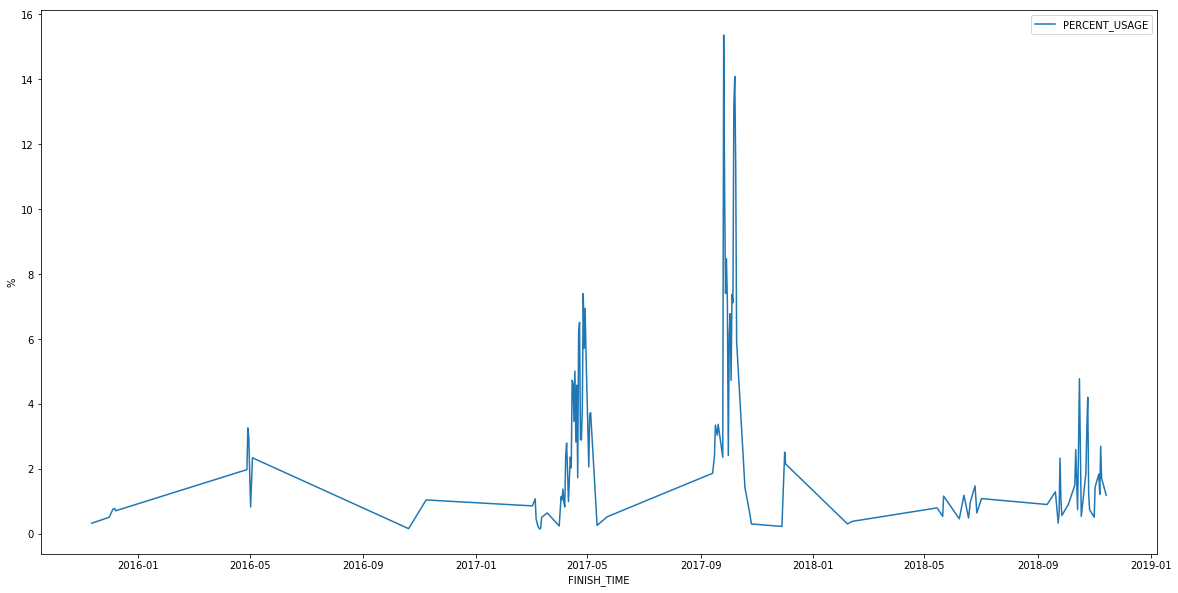

In [27]:
# excludes failed records
filter_success_df = df.loc[df['RESULT'] == 'Success']
filter_classroom_record_df = filter_success_df.copy()
filter_classroom_record_df['DATE'] = filter_success_df['FINISH_TIME'].dt.date

classroom_use_project_date_df = classroom_use_df.reset_index()[['PROJECT_ID', 'FINISH_TIME']]
classroom_use_project_date_df.columns = ['PROJECT_ID', 'DATE']

filter_classroom_record_df = pd.merge(filter_classroom_record_df, classroom_use_project_date_df, on=['PROJECT_ID', 'DATE'], how='inner')

normalized_classroom_yearly_usage_df = filter_classroom_record_df.groupby(filter_classroom_record_df['FINISH_TIME'].dt.date).apply(usage_f)
normalized_classroom_yearly_usage_df = normalized_classroom_yearly_usage_df.reset_index()[['FINISH_TIME', 'TOTAL_VCPUS']]
normalized_classroom_yearly_usage_df['AVAILABLE_VCPUS'] = [6000.0 if str(d) < '2017-07-14' else 3848.0 for d in normalized_classroom_yearly_usage_df['FINISH_TIME']]
normalized_classroom_yearly_usage_df['PERCENT_USAGE'] = (normalized_classroom_yearly_usage_df['TOTAL_VCPUS'] / normalized_classroom_yearly_usage_df['AVAILABLE_VCPUS']) * 100
normalized_classroom_yearly_usage_df = normalized_classroom_yearly_usage_df[['FINISH_TIME', 'PERCENT_USAGE']].set_index('FINISH_TIME')
normalized_classroom_yearly_usage_df
ax = normalized_classroom_yearly_usage_df.plot(figsize = (20, 10))
ax.set_ylabel('%')
plt.show()